# MDC 018 - Projeto Final

In [ ]:
model_name = "klue/roberta-small"
num_labels = 2
output_dir = "./results_critic_robertasmall"

In [1]:
import pandas as pd

# Carregando os dados de treinamento e teste
train_critic = pd.read_csv("train_critic.csv")

test_critic = pd.read_csv("test_critic.csv")

In [2]:
train_critic

,Show,Sentiment,Review
0,Bodyguard,1,"This has been a brilliant, compulsive, five-st..."
1,Mad Men,0,"With each new season, I try to remind myself t..."
2,1971: The Year That Music Changed Everything,1,Here's one of the most all-encompassing and st...
3,Six Feet Under,1,"To me, it was one of the most clever, funny, s..."
4,Pieces of Her,0,"Well acted and highly suspenseful, the eight-p..."
...,...,...,...
11827,Freaks and Geeks,1,Freaks and Geeks boasts an extremely talented ...
11828,The Gilded Age,1,It's a period piece set in 1882 New York that ...
11829,Joe vs Carole,1,McKinnon and her co-producers must be credited...
11830,Rick and Morty,1,"As season openers go, this is a really solid e..."


Verificação de balanceamento:

In [3]:
train_critic['Sentiment'].value_counts()


Sentiment
1    9995
0    1837
Name: count, dtype: int64

Ambos conjuntos estão fortemente desbalanceados.

# Predição de sentimento

Conjunto train_critic

In [4]:
# Separação entre conjunto de treino e validação
from sklearn.model_selection import train_test_split

# Remove NAs
train_critic.dropna(subset=['Review'], inplace=True)

(train_critic_df, val_critic_df) = train_test_split(train_critic, test_size=0.2)
train_critic_df['Sentiment'].value_counts()

Sentiment
1    8012
0    1452
Name: count, dtype: int64

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular os pesos para as classes
classes = train_critic['Sentiment'].unique()
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(classes),
    y=train_critic['Sentiment']
)

class_weights = dict(zip(classes, weights))
class_weights

{np.int64(1): np.float64(0.5918459229614808),
 np.int64(0): np.float64(3.221949891067538)}

In [6]:
val_critic_texts = val_critic_df["Review"].tolist()
val_critic_labels = val_critic_df["Sentiment"].tolist()

In [7]:
from sklearn.metrics import balanced_accuracy_score
from transformers import pipeline
import matplotlib.pyplot as plt

def get_balanced_accuracy(model, tokenizer, texts, labels):
    classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
    predictions = []

    for text in texts:
        result = classifier(text)
        label = int(result[0]["label"].split("_")[-1])
        predictions.append(label)
    return round(float(balanced_accuracy_score(labels, predictions)),2)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_confusion_matrix(trainer, dataset, label_names=None, cmap="Blues"):
    predictions_output = trainer.predict(dataset)
    logits = predictions_output.predictions
    labels = predictions_output.label_ids
    predictions = logits.argmax(axis=-1)
    cm = confusion_matrix(labels, predictions,  normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=cmap, values_format=".2f")
    plt.show()
    return cm

C:\Users\p.moura\.virtualenvs\mdc-projeto-final\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np
from datasets import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.metrics import balanced_accuracy_score

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained(model_name)
# Supondo que 'labels' contenha todos os rótulos do conjunto de treinamento
labels = train_critic['Sentiment']  # Altere para acessar os rótulos no seu dataset

C:\Users\p.moura\.virtualenvs\mdc-projeto-final\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\p.moura\.cache\huggingface\hub\models--prajjwal1--bert-medium. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at p

In [9]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)  # Converta para um tensor PyTorch
import torch.nn as nn

#tokeniza os datasets
train_encodings = tokenizer(train_critic_df['Review'].tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_critic_df['Review']), truncation=True, padding=True, max_length=128)

In [10]:
class CustomTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # Define a função de perda com os pesos de classe
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [11]:
import evaluate
from sklearn.metrics import balanced_accuracy_score

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric.compute(predictions=predictions, references=labels)
    return accuracy

def compute_metrics_balanced(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calcular acurácia balanceada
    balanced_acc = balanced_accuracy_score(labels, predictions)

    return {"balanced_accuracy": balanced_acc}

In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=5e-5,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    eval_strategy="epoch",
    load_best_model_at_end=True,               # Carregar o melhor modelo ao final
    metric_for_best_model="balanced_accuracy", # Métrica para determinar o melhor modelo
    save_strategy="epoch",                     # Salvar checkpoints no final de cada época
    save_total_limit=1,                        # Limitar os checkpoints a 1 para economizar espaço
    greater_is_better=True                     # Se maior métrica significa melhor modelo
)
train_critic_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': list(train_critic_df['Sentiment'])
})

val_critic_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': list(val_critic_df['Sentiment'])
})

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_critic_dataset,
    eval_dataset=val_critic_dataset,
    class_weights=class_weights,
    compute_metrics=compute_metrics_balanced
)
trainer.train()

Epoch,Training Loss,Validation Loss


In [25]:
get_balanced_accuracy(model, tokenizer, val_critic_texts, val_critic_labels)

0.79

In [26]:
trainer.evaluate()

{'eval_loss': 0.9255297780036926,
 'eval_balanced_accuracy': 0.7872394704646327,
 'eval_runtime': 18.6897,
 'eval_samples_per_second': 126.647,
 'eval_steps_per_second': 15.838,
 'epoch': 8.0}

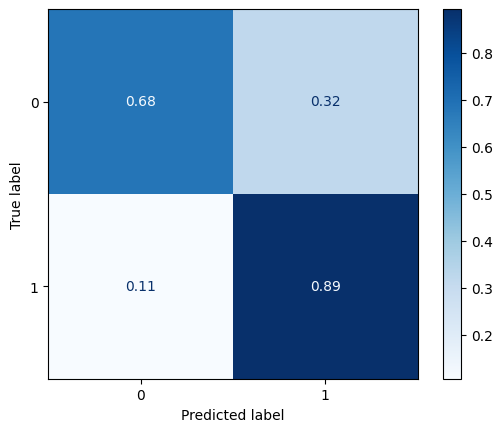

array([[0.68131868, 0.31868132],
       [0.10683974, 0.89316026]])

In [27]:
plot_confusion_matrix(trainer,val_critic_dataset)

# Teste

In [28]:
test_critic_texts = test_critic["Review"].tolist()
test_critic_labels = test_critic["Sentiment"].tolist()
get_balanced_accuracy(model, tokenizer, test_critic_texts, test_critic_labels)

0.77

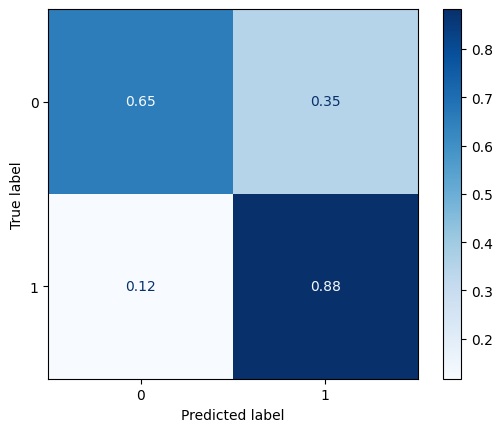

array([[0.65478842, 0.34521158],
       [0.11713147, 0.88286853]])

In [29]:
test_encodings = tokenizer(list(test_critic['Review']), truncation=True, padding=True, max_length=128)
test_critic_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': list(test_critic['Sentiment'])
})
plot_confusion_matrix(trainer,test_critic_dataset)